## Project Overview

This Jupyter Notebook is designed to replicate the plot from the research paper:
**'Segmented Arbitrage'** by Emil Siriwardane, Adi Sunderam, and Jonathan Wallen.



### Objective
The focus is on equity spot-futures arbitrage spreads using data from the **S&P 500 (SPX), Nasdaq 100 (NDX), and Dow Jones Industrial Average (DJI)**.

We follow the methodology outlined in the paper to compute arbitrage-implied forward rates:

$$ 1 + f_{\tau1,\tau2,t} = \frac{F_{t,\tau2} + E^Q_t[D_{t,\tau2}]}{F_{t,\tau1} + E^Q_t[D_{t,\tau1}]} $$

The arbitrage spread is computed as:

$$ ESF_t = f_{\tau1,\tau2,t} - OIS3M_t $$

This notebook provides an explanation of the code implementation and presents the final visualization.

### Reference Paper
You can access the full paper here: [Segmented Arbitrage](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3960980)



## 1. Overview of the Dataset

The dataset consists of **spot prices, futures contracts, and Overnight Index Swap (OIS) rates**.
This section displays a preview of the dataset and checks for missing values and overall data quality.

In [ ]:
from compute_calendar_spread_OIS3M import *

print("First few rows of the dataset:")
display(merged_df.head())

print("Summary statistics of arbitrage spreads:")
display(merged_df[["SPX_arb_spread", "NDX_arb_spread", "DJI_arb_spread"]].describe())

print("Checking missing values per column:")
display(merged_df.isnull().sum())

First few rows of the dataset:


,SPX_Spot,SPX_Div,NDX_Spot,NDX_Div,DJI_Spot,DJI_Div,SPX_F1,SPX_F2,SPX_Contract,SPX_Contract2,...,NDX_implied_forward_raw,NDX_annualized_forward_bps,NDX_OIS_bps,NDX_arb_spread,DJI_exp_tau1_comp,DJI_exp_tau2_comp,DJI_implied_forward_raw,DJI_annualized_forward_bps,DJI_OIS_bps,DJI_arb_spread
2010-01-04,1132.98,0.058362,1886.70,0.148515,10583.96,0.377875,1128.75,1124.00,MAR 10,JUN 10,...,0.000468,18.512824,16.2,2.312824,66.375291,133.155773,0.000641,25.340514,16.2,9.140514
2010-01-05,1136.52,0.001744,1888.43,0.000000,10572.02,0.000000,1132.25,1127.50,MAR 10,JUN 10,...,0.000336,13.287479,15.5,-2.212521,66.374670,133.153351,0.000641,25.343360,15.5,9.843360
2010-01-06,1137.14,0.497980,1878.42,0.000000,10573.68,6.763957,1133.00,1128.00,MAR 10,JUN 10,...,0.000470,18.590380,14.6,3.990380,59.608986,126.384160,0.000546,21.603335,14.6,7.003335
2010-01-07,1141.70,0.061819,1876.72,0.000000,10606.86,1.360349,1137.50,1132.50,MAR 10,JUN 10,...,0.000204,8.079854,14.5,-6.420146,58.248263,125.022826,0.000545,21.544746,14.5,7.044746
2010-01-08,1144.98,0.000000,1892.59,0.000000,10618.19,0.000000,1141.50,1136.75,MAR 10,JUN 10,...,0.000071,2.800655,14.3,-11.499345,58.248032,125.022016,0.000543,21.500000,14.3,7.200000


Summary statistics of arbitrage spreads:


,SPX_arb_spread,NDX_arb_spread,DJI_arb_spread
count,3454.000000,3454.000000,3454.000000
mean,40.186810,35.320902,43.557842
std,25.628959,26.911136,29.779915
min,-127.295414,-76.408418,-194.538458
25%,24.163614,16.939950,24.299931
50%,40.702128,35.396079,41.696733
75%,52.973603,50.660372,58.548681
max,235.376015,239.481060,379.066696


Checking missing values per column:


SPX_Spot                      0
SPX_Div                       0
NDX_Spot                      0
NDX_Div                       0
DJI_Spot                      0
DJI_Div                       0
SPX_F1                        0
SPX_F2                        0
SPX_Contract                  0
SPX_Contract2                 0
NDX_F1                        0
NDX_F2                        0
NDX_Contract                  0
NDX_Contract2                 0
DJI_F1                        0
DJI_F2                        0
DJI_Contract                  0
DJI_Contract2                 0
OIS_3M                        0
SPX_TTM1                      0
SPX_TTM2                      0
NDX_TTM1                      0
NDX_TTM2                      0
DJI_TTM1                      0
DJI_TTM2                      0
SPX_exp_tau1                  0
SPX_exp_tau2                  0
SPX_daily_div                 0
NDX_exp_tau1                  0
NDX_exp_tau2                  0
NDX_daily_div                 0
DJI_exp_

## 2. Expected Dividends Computation

To compute expected dividends, we assume **perfect foresight dividends**, which means we use actual realized dividends to approximate expected values.

This step calculates:
- **τ₁ (exp_tau1)**: Expected dividend during the first futures contract period
- **τ₂ (exp_tau2)**: Expected dividend for the next contract period
- **Daily dividend**: Derived from historical dividend data

```python
for idx in ["SPX", "NDX", "DJI"]:
    # Compute τ₁ using the primary contract field
    exp_tau1, _, daily_div,_ = compute_expected_dividend(
        merged_df, div_col=f"{idx}_Div", contract_col=f"{idx}_Contract"
    )
    # Compute τ₂ using the deferred contract field (i.e. the next contract)
    # We ignore the τ₁ output from this call because we want τ₂ to come entirely from the deferred contract grouping.
    _, exp_tau2, _,total_div = compute_expected_dividend(
        merged_df, div_col=f"{idx}_Div", contract_col=f"{idx}_Contract2"
    )
    merged_df[f"{idx}_exp_tau1"] = exp_tau1
    merged_df[f"{idx}_exp_tau2"] = exp_tau1 + total_div
    merged_df[f"{idx}_daily_div"] = daily_div


```

In [12]:

print("Expected Dividends for SPX:")
display(merged_df[["SPX_exp_tau1", "SPX_exp_tau2", "SPX_daily_div"]].head())

print("Expected Dividends for NDX:")
display(merged_df[["NDX_exp_tau1", "NDX_exp_tau2", "NDX_daily_div"]].head())

print("Expected Dividends for DJI:")
display(merged_df[["DJI_exp_tau1", "DJI_exp_tau2", "DJI_daily_div"]].head())

Expected Dividends for SPX:


,SPX_exp_tau1,SPX_exp_tau2,SPX_daily_div
2010-01-04,4.840390,9.739142,0.058362
2010-01-05,4.838646,9.737398,0.001744
2010-01-06,4.340666,9.239418,0.497980
2010-01-07,4.278847,9.177599,0.061819
2010-01-08,4.278847,9.177599,0.000000


Expected Dividends for NDX:


,NDX_exp_tau1,NDX_exp_tau2,NDX_daily_div
2010-01-04,2.734064,5.616643,0.148515
2010-01-05,2.734064,5.616643,0.000000
2010-01-06,2.734064,5.616643,0.000000
2010-01-07,2.734064,5.616643,0.000000
2010-01-08,2.734064,5.616643,0.000000


Expected Dividends for DJI:


,DJI_exp_tau1,DJI_exp_tau2,DJI_daily_div
2010-01-04,66.364241,133.106357,0.377875
2010-01-05,66.364241,133.106357,0.000000
2010-01-06,59.600284,126.342400,6.763957
2010-01-07,58.239935,124.982051,1.360349
2010-01-08,58.239935,124.982051,0.000000


## 3. Outlier Detection and Cleaning

To ensure accuracy, we remove extreme outliers in the arbitrage spread using a rolling **Median Absolute Deviation (MAD)** filter.
Outliers are defined as values more than **5 times the rolling MAD**.


```python

for idx in ["SPX", "NDX", "DJI"]:
    arb_series = merged_df[f"{idx}_arb_spread"]
    rolling_median = arb_series.rolling(window='45D', center=True).median()
    abs_dev = (arb_series - rolling_median).abs()
    rolling_mad = abs_dev.rolling(window='45D', center=True).mean()
    outliers = (abs_dev / rolling_mad) >= 5
    merged_df.loc[outliers, f"{idx}_annualized_forward_bps"] = np.nan
    merged_df[f"{idx}_arb_spread"] = merged_df[f"{idx}_annualized_forward_bps"] - merged_df[f"{idx}_OIS_bps"]

```

## 3. Visualization of Arbitrage Spreads

This section plots the arbitrage spread for SPX, NDX, and DJI over time.
The arbitrage spread is defined as the difference between the implied forward rate and the OIS3M rate.

A positive spread indicates that the implied forward rate is greater than the risk-free OIS rate, suggesting **potential mispricing**.

### Reference Plot from the Paper
Below is the original figure from the research paper that we aim to replicate:

<img src="../data_manual/plot_research_paper.png" />

### Replicated Arbitrage Spread Plot
The following plot is generated from our computed data to match the paper’s findings.

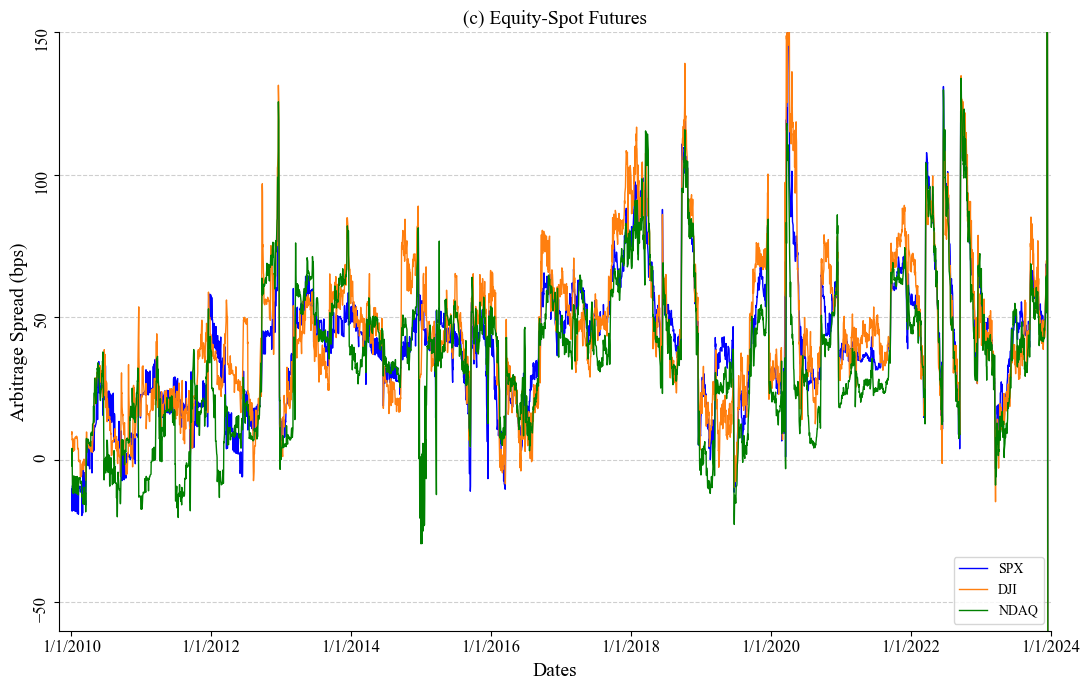

In [25]:
plt.figure(figsize=(11, 7))
plt.rcParams["font.family"] = "Times New Roman"
plt.plot(merged_df.index, merged_df["SPX_arb_spread"], label="SPX", color="blue", linewidth=1)
plt.plot(merged_df.index, merged_df["DJI_arb_spread"], label="DJI", color=dji_color, linewidth=1)
plt.plot(merged_df.index, merged_df["NDX_arb_spread"], label="NDAQ", color="green", linewidth=1)
plt.xlabel("Dates", fontsize=14)
plt.xlim([datetime(2009, 11, 1), datetime(2024, 1, 1)])
plt.ylim([-60, 150])
plt.yticks(np.arange(-50, 151, 50))
plt.gca().yaxis.set_tick_params(rotation=90, labelsize=12)
plt.xticks(fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.ylabel("Arbitrage Spread (bps)", fontsize=14)
plt.title("(c) Equity-Spot Futures", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(fontsize=10, loc="lower right")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%-m/%-d/%Y'))
plt.tight_layout()
plt.show()


## 5. Conclusion and Next Steps

### Key Insights:
- Arbitrage spreads are computed as the difference between **futures-implied risk-free rates** and **OIS3M risk-free rates**.
- Data processing includes:
  - Extracting **spot prices, futures contracts, and interest rate data**
  - Computing **expected dividends**
  - Removing **outliers in arbitrage spreads**
- The **final plot** visualizes arbitrage spreads for SPX, NDX, and DJI over time.

### Next Steps and Potential Applications:
- Investigate alternative data sources for **dividends and risk-free rates**.
- Conduct further **robustness checks** to validate computed spreads.
- Expand analysis to other arbitrage opportunities such as **put-call parity and CDS-bond spreads**.

This analysis provides a solid foundation for **replicating the research paper's methodology** and further refining the arbitrage spread computation.